In [9]:
%pylab inline
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
import hmf
import haloSim
import simutil
from cosmology import Cosmo
cosmo   =   Cosmo(h=1,omega_m=0.315)

from configparser import ConfigParser
from pixel3D import cartesianGrid3D
from scipy.interpolate import griddata
if False:
    figMsDir='/work/xiangchong.li/superonionGW/code/massMap_Private/doc/paper_ms_method_HSCY1/'
else:
    figMsDir='/home/xiangchong/Documents/Docs/massMap/paper_HSC2021/'
cmap=plt.get_cmap('tab20')

Populating the interactive namespace from numpy and matplotlib


/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [11]:
configName  =   'wrkDir/config-nl10.ini'
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)
print(gridInfo.zlcgrid)
lensKer0=gridInfo.lensing_kernel(deltaIn=False)

[0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4 ]


In [12]:
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=14.,Mmax=14.6,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>


5694.029147189548
62928.97038772607
137552.16320642337
194144.86740703843


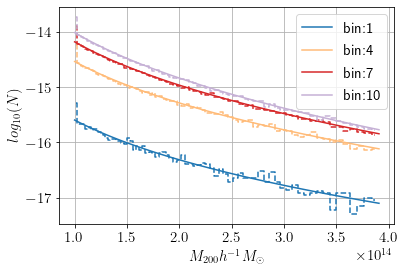

In [18]:
plt.close()
nsamp=25
zbound=gridInfo.zlbound
zmin=zbound[:-1]
zmax=zbound[1:]
zave=(zmin+zmax)/2.
nscale=1e18

zlist=[]
mlist=[]
nlist=[]
for iz in range(0,10,3):
    z=zave[iz]
    mf.update(z=z)
    v=cosmo.V(zmin[iz],zmax[iz])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m
    msample=[]
    sAll=np.sum(mass_func)
    for i in range(int(sAll*nscale)):
        msample.append(simutil.mcSample(m,mass_func))
    msample=np.array(msample)
    y=np.histogram(msample,bins=m)[0]
    plt.plot(m,np.log10(mass_func),label='bin:%d' %(iz+1),color=cmap(iz))
    plt.step((mf.m[1:]+mf.m[:-1])/2.,np.log10(y/nscale),where='mid',color=cmap(iz),ls='--')
    print(sAll*nscale)
plt.xlabel(r'$M_{200} h^{-1}M_{\odot}$')
plt.ylabel(r'$log_{10}(N)$')
plt.legend()
plt.grid()

In [5]:
iz=0
nscale=1e19
z=zave[iz]
mf.update(z=z)
v=cosmo.V(zmin[iz],zmax[iz])*np.pi**2./180.**2./4./np.pi
mass_func = mf.dndm*v
m = mf.m
msample=[]
sAll=np.sum(mass_func)
for i in range(int(sAll*nscale)):
    msample.append(simutil.mcSample(m,mass_func))
msample=np.array(msample)
conc =  6.02*(msample/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
rs_arcmin=haloSim.mc2rs(msample,conc,z)

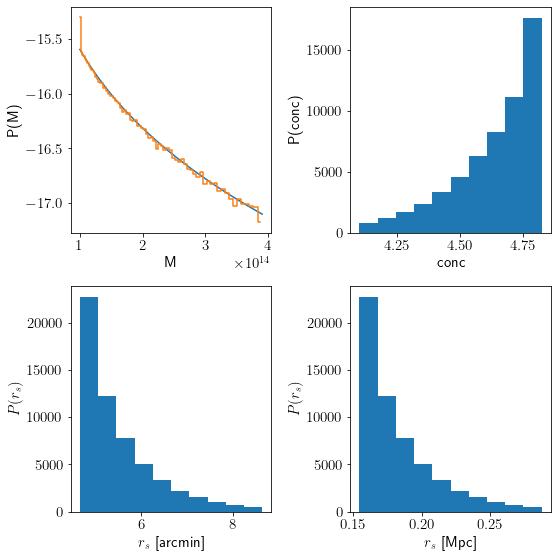

In [6]:
plt.close()
fig=plt.figure(figsize=(8,8))

ax=fig.add_subplot(2,2,1)
y=np.histogram(msample,bins=m)[0]
ax.plot(m,np.log10(mass_func/np.sum(mass_func)*sAll),label='bin:%d' %iz)
ax.step((mf.m[1:]+mf.m[:-1])/2.,np.log10(y/np.sum(y)*sAll),where='mid')
ax.set_xlabel('M')
ax.set_ylabel('P(M)')

ax=fig.add_subplot(2,2,2)
y=np.histogram(msample,bins=m)[0]
ax.hist(conc)
ax.set_xlabel('conc')
ax.set_ylabel('P(conc)')

ax=fig.add_subplot(2,2,3)
ax.hist(rs_arcmin)
ax.set_xlabel('$r_s$ [arcmin]')
ax.set_ylabel('$P(r_s)$')

ax=fig.add_subplot(2,2,4)
DaLens  =   cosmo.Da(0.,z) # angular distance in Mpc/h
arcmin2rad  =   np.pi/180./60.
rs       =   rs_arcmin*arcmin2rad* DaLens
ax.hist(rs)
ax.set_xlabel(r'$r_s$ [Mpc]')
ax.set_ylabel(r'$P(r_s)$')
plt.tight_layout()

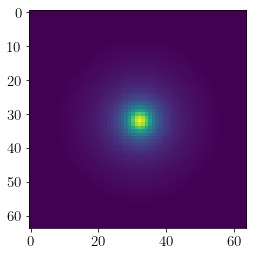

In [7]:
haloImg=haloSim.haloCS02SigmaAtom(rs_arcmin[0],64,64,c=conc[0],smooth_scale=1.5,fou=False,lnorm=1)*msample[0]
imshow(np.fft.fftshift(haloImg))

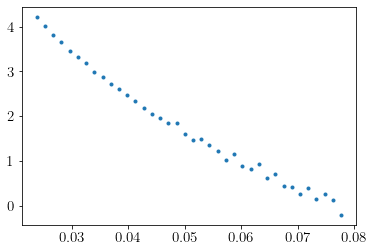

In [8]:
np.sqrt(np.sum((lensKer0.T[iz]*msample[0])**2.))
hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*msample,bins=40,density=True)
bave=(bounds[1:]+bounds[:-1])/2.
plt.scatter(bave[2:],np.log(hist[2:]),marker='.')